# Load Data

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from zipfile import ZipFile
from PIL import Image 
from sklearn.preprocessing import scale
from sklearn import preprocessing

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader


In [3]:
transform = transforms.Compose([transforms.Normalize((0.5), (0.5))])

In [4]:
dirname = "D:\\images- Groeber\\new images\\Karthik Images"
imarray = []
for i in range(0,13800):
    im = Image.open("D:\\images- Groeber\\new images\\Karthik Images\\test-{}.tif".format(i))
    fi = np.array(im)
    imarray.append(fi)

# Remove Black Images

In [5]:
list1 = imarray.copy()
count = 0
for k in range(0,len(imarray)):
    if imarray[k].sum() == 0:
        list1.pop(k-count)  
        count += 1
        
len(list1)

8454

# Load class labels

In [6]:
Y_values = np.loadtxt('C:\\Users\\karna\\Downloads\\Karthik Flags.txt')
Y10 = Y_values[:,10] 

Y10_unique = np.unique(Y10)
print(Y10_unique)
count = 0
for k in range(0,len(imarray)):
    if imarray[k].sum() == 0:
        Y10 = np.delete(Y10,[k-count],None)  
        count += 1

Y10.shape

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


(8454,)

In [7]:
classes=(np.array(range(0,31)))

In [8]:
classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [9]:
len(list1)

8454

In [10]:
Y2 = Y_values[:,2] 

Y2_unique = np.unique(Y2)
print(Y2_unique)
count = 0
for k in range(0,len(imarray)):
    if imarray[k].sum() == 0:
        Y2 = np.delete(Y2,[k-count],None)  
        count += 1

Y2.shape

[0.]


(8454,)

In [11]:
Y9 = Y_values[:,9] 

Y9_unique = np.unique(Y9)
print(Y9_unique)
count = 0
for k in range(0,len(imarray)):
    if imarray[k].sum() == 0:
        Y9 = np.delete(Y9,[k-count],None)  
        count += 1


[0. 1. 2.]


# Train Test Split

In [12]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(list1, Y9, test_size=0.33,shuffle=True)

In [13]:
from collections import Counter

Counter(Y9).keys() # equals to list(set(words))

for i,k in enumerate(Y9_unique):
    print(k,"  ",list(Counter(Y_train).values())[i]) # counts the elements' frequency

0.0    2908
1.0    781
2.0    1975


In [14]:
(Counter(Y_train).values())

dict_values([2908, 781, 1975])

In [15]:
sum(Y_train==0)

2908

In [16]:
sum(Y_train==1)

1975

In [17]:
sum(Y_train==2)

781

In [18]:
for i,k in enumerate(Y9_unique):
    print(i,k)

0 0.0
1 1.0
2 2.0


In [19]:
data1 = np.ndarray(shape=(len(X_train), X_train[0].shape[0], X_train[0].shape[1]), dtype=np.float32)

for j in range(0,len(X_train)):
    data1[j] = X_train[j]

In [20]:
print(len(X_train))
print(len(X_test))
print(X_train[1].shape)
print(Y_train.shape)
print(Y_test.shape)
type(Y_train)

5664
2790
(512, 128)
(5664,)
(2790,)


numpy.ndarray

### load the data onto the GPU

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda


# Load X and Y into the PyTorch data loader

In [22]:
my_x = X_train  # a list of numpy arrays
my_y = Y_train     # numpy array (targets)


class myDataset(Dataset):

    # Initialize your data, download, etc.
    def __init__(self,X,Y,transform=None):
        self.len = len(X)
        self.transform = transform
        self.x_data = X
        self.x_data = torch.FloatTensor(self.x_data).view(-1,1,512,128)
        self.y_data = torch.from_numpy(Y)
        self.y_data = self.y_data.long()

    def __getitem__(self, index):
        x = self.x_data[index]
        y = self.y_data[index]
        if self.transform:
            x=self.transform(x)
        return x,y
    
    def __len__(self):
        return self.len

In [23]:
xdataset = myDataset(X_train,Y_train,transform=None)
train_loader = DataLoader(dataset=xdataset,batch_size=32,
                          shuffle=True)

In [24]:
ydataset = myDataset(X_test,Y_test,transform=None)
test_loader = DataLoader(dataset=ydataset,batch_size=32,
                          shuffle=True)

In [25]:
type(xdataset.y_data)

torch.Tensor

# Build a CNN

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #convolutional_layers
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.conv5 = nn.Conv2d(64,128,3)
        
        #pooling_layer
        self.pool = nn.MaxPool2d(2, 2)
        
        #batch_normalization
        self.b_n1 = nn.BatchNorm2d(6)
        self.b_n2 = nn.BatchNorm2d(16)
        self.b_n3 = nn.BatchNorm2d(32)
        self.b_n4 = nn.BatchNorm2d(64)
        self.b_n5 = nn.BatchNorm2d(128)
        
        #dense/fully_connected_layers
        self.fc1 = nn.Linear(128 * 14 * 2, 7000)
        self.fc2 = nn.Linear(7000,4000)
        self.fc3 = nn.Linear(4000,2000)
        self.fc4 = nn.Linear(2000,1000)
        self.fc5 = nn.Linear(1000,500)
        self.fc6 = nn.Linear(500,100)
        self.fc7 = nn.Linear(100,3)
                        
    #Feed Forward network
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.b_n1(x)
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.b_n2(x)
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.b_n3(x)
        x = self.pool(F.leaky_relu(self.conv4(x)))
        x = self.b_n4(x)
        x = self.pool(F.leaky_relu(self.conv5(x)))
        x = self.b_n5(x)
        
        #Flatten the layer
        x = x.view(-1, 128 * 14 * 2)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x


net = Net().to(device)

# Optimizer

In [99]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

In [101]:
net_SGD = Net().to(device)
net_Momentum = Net().to(device)
net_RMSprop = Net().to(device)
net_Adam = Net().to(device)

opt_SGD = torch.optim.SGD(net_SGD.parameters(),lr=0.1)
opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr = 0.001, momentum = 0.9)
opt_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(), lr = 0.001, alpha = 0.99)
opt_Adam = torch.optim.Adam(net_Adam.parameters(),lr=0.001)

name=["SGD","Momentum","RMSprop","Adam"]
nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam]
optimizers = [opt_SGD, opt_Momentum, opt_RMSprop, opt_Adam]

In [102]:
SGDl = []
Moml = []
RMSl = []
Adaml = []

SGDa = []
Moma = []
RMSa = []
Adama = []

In [103]:
total = 0
correct = 0

for epoch in range(20):  # loop over the dataset multiple times (30 passes of all the training samples through 176 batches of 32)

    running_loss = 0.0
    r_l = 0.0
    for i, data in enumerate(train_loader,0):
        # get the inputs
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        for l,net,optimizer in zip(name,nets,optimizers):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            _,predicted = torch.max(outputs.data,1)
        
            total += labels.size(0)
            correct += (predicted == labels).sum()
            if i % 10 == 9:    # print every 10 mini-batches
                print(l,"(Epoch:",epoch+1,"; Batch:",i+1,")")
                print('[%2d, %3d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                if l=="SGD":
                    SGDl.append(running_loss/10)
                    SGDa.append(round((float(correct) / total),2))
                elif l=="Momentum":
                    Moml.append(running_loss/10)
                    Moma.append(round((float(correct) / total),2))
                elif l=="RMSprop":
                    RMSl.append(running_loss/10)
                    RMSa.append(round((float(correct) / total),2))
                elif l=="Adam":
                    Adaml.append(running_loss/10)
                    Adama.append(round((float(correct) / total),2))
                running_loss = 0.0
                correct = 0
                total = 0

print('Finished Training')

SGD (Epoch: 1 ; Batch: 10 )
[ 1,  10] loss: 740.603
Momentum (Epoch: 1 ; Batch: 10 )
[ 1,  10] loss: 0.109
RMSprop (Epoch: 1 ; Batch: 10 )
[ 1,  10] loss: 0.166
Adam (Epoch: 1 ; Batch: 10 )
[ 1,  10] loss: 0.065
SGD (Epoch: 1 ; Batch: 20 )
[ 1,  20] loss: 3.186
Momentum (Epoch: 1 ; Batch: 20 )
[ 1,  20] loss: 0.108
RMSprop (Epoch: 1 ; Batch: 20 )
[ 1,  20] loss: 0.080
Adam (Epoch: 1 ; Batch: 20 )
[ 1,  20] loss: 0.038
SGD (Epoch: 1 ; Batch: 30 )
[ 1,  30] loss: 2.949
Momentum (Epoch: 1 ; Batch: 30 )
[ 1,  30] loss: 0.106
RMSprop (Epoch: 1 ; Batch: 30 )
[ 1,  30] loss: 0.076
Adam (Epoch: 1 ; Batch: 30 )
[ 1,  30] loss: 0.048
SGD (Epoch: 1 ; Batch: 40 )
[ 1,  40] loss: 2.698
Momentum (Epoch: 1 ; Batch: 40 )
[ 1,  40] loss: 0.108
RMSprop (Epoch: 1 ; Batch: 40 )
[ 1,  40] loss: 0.038
Adam (Epoch: 1 ; Batch: 40 )
[ 1,  40] loss: 0.040
SGD (Epoch: 1 ; Batch: 50 )
[ 1,  50] loss: 2.854
Momentum (Epoch: 1 ; Batch: 50 )
[ 1,  50] loss: 0.106
RMSprop (Epoch: 1 ; Batch: 50 )
[ 1,  50] loss: 0.031

Adam (Epoch: 3 ; Batch: 50 )
[ 3,  50] loss: 0.014
SGD (Epoch: 3 ; Batch: 60 )
[ 3,  60] loss: 1.483
Momentum (Epoch: 3 ; Batch: 60 )
[ 3,  60] loss: 0.096
RMSprop (Epoch: 3 ; Batch: 60 )
[ 3,  60] loss: 0.039
Adam (Epoch: 3 ; Batch: 60 )
[ 3,  60] loss: 0.035
SGD (Epoch: 3 ; Batch: 70 )
[ 3,  70] loss: 1.670
Momentum (Epoch: 3 ; Batch: 70 )
[ 3,  70] loss: 0.085
RMSprop (Epoch: 3 ; Batch: 70 )
[ 3,  70] loss: 0.017
Adam (Epoch: 3 ; Batch: 70 )
[ 3,  70] loss: 0.011
SGD (Epoch: 3 ; Batch: 80 )
[ 3,  80] loss: 1.534
Momentum (Epoch: 3 ; Batch: 80 )
[ 3,  80] loss: 0.093
RMSprop (Epoch: 3 ; Batch: 80 )
[ 3,  80] loss: 0.028
Adam (Epoch: 3 ; Batch: 80 )
[ 3,  80] loss: 0.001
SGD (Epoch: 3 ; Batch: 90 )
[ 3,  90] loss: 1.496
Momentum (Epoch: 3 ; Batch: 90 )
[ 3,  90] loss: 0.103
RMSprop (Epoch: 3 ; Batch: 90 )
[ 3,  90] loss: 0.057
Adam (Epoch: 3 ; Batch: 90 )
[ 3,  90] loss: 0.102
SGD (Epoch: 3 ; Batch: 100 )
[ 3, 100] loss: 1.523
Momentum (Epoch: 3 ; Batch: 100 )
[ 3, 100] loss: 0.089
RM

Adam (Epoch: 5 ; Batch: 100 )
[ 5, 100] loss: 0.013
SGD (Epoch: 5 ; Batch: 110 )
[ 5, 110] loss: 1.082
Momentum (Epoch: 5 ; Batch: 110 )
[ 5, 110] loss: 0.060
RMSprop (Epoch: 5 ; Batch: 110 )
[ 5, 110] loss: 0.046
Adam (Epoch: 5 ; Batch: 110 )
[ 5, 110] loss: 0.007
SGD (Epoch: 5 ; Batch: 120 )
[ 5, 120] loss: 0.884
Momentum (Epoch: 5 ; Batch: 120 )
[ 5, 120] loss: 0.037
RMSprop (Epoch: 5 ; Batch: 120 )
[ 5, 120] loss: 0.024
Adam (Epoch: 5 ; Batch: 120 )
[ 5, 120] loss: 0.002
SGD (Epoch: 5 ; Batch: 130 )
[ 5, 130] loss: 0.812
Momentum (Epoch: 5 ; Batch: 130 )
[ 5, 130] loss: 0.042
RMSprop (Epoch: 5 ; Batch: 130 )
[ 5, 130] loss: 0.045
Adam (Epoch: 5 ; Batch: 130 )
[ 5, 130] loss: 0.003
SGD (Epoch: 5 ; Batch: 140 )
[ 5, 140] loss: 0.851
Momentum (Epoch: 5 ; Batch: 140 )
[ 5, 140] loss: 0.057
RMSprop (Epoch: 5 ; Batch: 140 )
[ 5, 140] loss: 0.043
Adam (Epoch: 5 ; Batch: 140 )
[ 5, 140] loss: 0.005
SGD (Epoch: 5 ; Batch: 150 )
[ 5, 150] loss: 0.781
Momentum (Epoch: 5 ; Batch: 150 )
[ 5, 15

Adam (Epoch: 7 ; Batch: 150 )
[ 7, 150] loss: 0.003
SGD (Epoch: 7 ; Batch: 160 )
[ 7, 160] loss: 0.628
Momentum (Epoch: 7 ; Batch: 160 )
[ 7, 160] loss: 0.036
RMSprop (Epoch: 7 ; Batch: 160 )
[ 7, 160] loss: 0.043
Adam (Epoch: 7 ; Batch: 160 )
[ 7, 160] loss: 0.004
SGD (Epoch: 7 ; Batch: 170 )
[ 7, 170] loss: 0.599
Momentum (Epoch: 7 ; Batch: 170 )
[ 7, 170] loss: 0.045
RMSprop (Epoch: 7 ; Batch: 170 )
[ 7, 170] loss: 0.037
Adam (Epoch: 7 ; Batch: 170 )
[ 7, 170] loss: 0.011
SGD (Epoch: 8 ; Batch: 10 )
[ 8,  10] loss: 0.674
Momentum (Epoch: 8 ; Batch: 10 )
[ 8,  10] loss: 0.027
RMSprop (Epoch: 8 ; Batch: 10 )
[ 8,  10] loss: 0.026
Adam (Epoch: 8 ; Batch: 10 )
[ 8,  10] loss: 0.003
SGD (Epoch: 8 ; Batch: 20 )
[ 8,  20] loss: 1.570
Momentum (Epoch: 8 ; Batch: 20 )
[ 8,  20] loss: 0.034
RMSprop (Epoch: 8 ; Batch: 20 )
[ 8,  20] loss: 0.032
Adam (Epoch: 8 ; Batch: 20 )
[ 8,  20] loss: 0.001
SGD (Epoch: 8 ; Batch: 30 )
[ 8,  30] loss: 0.720
Momentum (Epoch: 8 ; Batch: 30 )
[ 8,  30] loss: 0

Adam (Epoch: 10 ; Batch: 30 )
[10,  30] loss: 0.001
SGD (Epoch: 10 ; Batch: 40 )
[10,  40] loss: 0.424
Momentum (Epoch: 10 ; Batch: 40 )
[10,  40] loss: 0.047
RMSprop (Epoch: 10 ; Batch: 40 )
[10,  40] loss: 0.046
Adam (Epoch: 10 ; Batch: 40 )
[10,  40] loss: 0.027
SGD (Epoch: 10 ; Batch: 50 )
[10,  50] loss: 0.545
Momentum (Epoch: 10 ; Batch: 50 )
[10,  50] loss: 0.025
RMSprop (Epoch: 10 ; Batch: 50 )
[10,  50] loss: 0.002
Adam (Epoch: 10 ; Batch: 50 )
[10,  50] loss: 0.002
SGD (Epoch: 10 ; Batch: 60 )
[10,  60] loss: 0.532
Momentum (Epoch: 10 ; Batch: 60 )
[10,  60] loss: 0.036
RMSprop (Epoch: 10 ; Batch: 60 )
[10,  60] loss: 0.008
Adam (Epoch: 10 ; Batch: 60 )
[10,  60] loss: 0.007
SGD (Epoch: 10 ; Batch: 70 )
[10,  70] loss: 0.448
Momentum (Epoch: 10 ; Batch: 70 )
[10,  70] loss: 0.039
RMSprop (Epoch: 10 ; Batch: 70 )
[10,  70] loss: 0.037
Adam (Epoch: 10 ; Batch: 70 )
[10,  70] loss: 0.002
SGD (Epoch: 10 ; Batch: 80 )
[10,  80] loss: 0.380
Momentum (Epoch: 10 ; Batch: 80 )
[10,  8

Adam (Epoch: 12 ; Batch: 70 )
[12,  70] loss: 0.007
SGD (Epoch: 12 ; Batch: 80 )
[12,  80] loss: 0.331
Momentum (Epoch: 12 ; Batch: 80 )
[12,  80] loss: 0.020
RMSprop (Epoch: 12 ; Batch: 80 )
[12,  80] loss: 0.014
Adam (Epoch: 12 ; Batch: 80 )
[12,  80] loss: 0.011
SGD (Epoch: 12 ; Batch: 90 )
[12,  90] loss: 0.297
Momentum (Epoch: 12 ; Batch: 90 )
[12,  90] loss: 0.010
RMSprop (Epoch: 12 ; Batch: 90 )
[12,  90] loss: 0.005
Adam (Epoch: 12 ; Batch: 90 )
[12,  90] loss: 0.003
SGD (Epoch: 12 ; Batch: 100 )
[12, 100] loss: 0.324
Momentum (Epoch: 12 ; Batch: 100 )
[12, 100] loss: 0.013
RMSprop (Epoch: 12 ; Batch: 100 )
[12, 100] loss: 0.006
Adam (Epoch: 12 ; Batch: 100 )
[12, 100] loss: 0.008
SGD (Epoch: 12 ; Batch: 110 )
[12, 110] loss: 0.340
Momentum (Epoch: 12 ; Batch: 110 )
[12, 110] loss: 0.015
RMSprop (Epoch: 12 ; Batch: 110 )
[12, 110] loss: 0.018
Adam (Epoch: 12 ; Batch: 110 )
[12, 110] loss: 0.007
SGD (Epoch: 12 ; Batch: 120 )
[12, 120] loss: 0.345
Momentum (Epoch: 12 ; Batch: 120

Adam (Epoch: 14 ; Batch: 110 )
[14, 110] loss: 0.014
SGD (Epoch: 14 ; Batch: 120 )
[14, 120] loss: 0.201
Momentum (Epoch: 14 ; Batch: 120 )
[14, 120] loss: 0.003
RMSprop (Epoch: 14 ; Batch: 120 )
[14, 120] loss: 0.004
Adam (Epoch: 14 ; Batch: 120 )
[14, 120] loss: 0.000
SGD (Epoch: 14 ; Batch: 130 )
[14, 130] loss: 0.430
Momentum (Epoch: 14 ; Batch: 130 )
[14, 130] loss: 0.006
RMSprop (Epoch: 14 ; Batch: 130 )
[14, 130] loss: 0.000
Adam (Epoch: 14 ; Batch: 130 )
[14, 130] loss: 0.008
SGD (Epoch: 14 ; Batch: 140 )
[14, 140] loss: 0.264
Momentum (Epoch: 14 ; Batch: 140 )
[14, 140] loss: 0.009
RMSprop (Epoch: 14 ; Batch: 140 )
[14, 140] loss: 0.004
Adam (Epoch: 14 ; Batch: 140 )
[14, 140] loss: 0.006
SGD (Epoch: 14 ; Batch: 150 )
[14, 150] loss: 0.179
Momentum (Epoch: 14 ; Batch: 150 )
[14, 150] loss: 0.006
RMSprop (Epoch: 14 ; Batch: 150 )
[14, 150] loss: 0.003
Adam (Epoch: 14 ; Batch: 150 )
[14, 150] loss: 0.006
SGD (Epoch: 14 ; Batch: 160 )
[14, 160] loss: 0.208
Momentum (Epoch: 14 ; B

Adam (Epoch: 16 ; Batch: 150 )
[16, 150] loss: 0.014
SGD (Epoch: 16 ; Batch: 160 )
[16, 160] loss: 0.197
Momentum (Epoch: 16 ; Batch: 160 )
[16, 160] loss: 0.013
RMSprop (Epoch: 16 ; Batch: 160 )
[16, 160] loss: 0.015
Adam (Epoch: 16 ; Batch: 160 )
[16, 160] loss: 0.009
SGD (Epoch: 16 ; Batch: 170 )
[16, 170] loss: 0.256
Momentum (Epoch: 16 ; Batch: 170 )
[16, 170] loss: 0.005
RMSprop (Epoch: 16 ; Batch: 170 )
[16, 170] loss: 0.013
Adam (Epoch: 16 ; Batch: 170 )
[16, 170] loss: 0.001
SGD (Epoch: 17 ; Batch: 10 )
[17,  10] loss: 0.149
Momentum (Epoch: 17 ; Batch: 10 )
[17,  10] loss: 0.002
RMSprop (Epoch: 17 ; Batch: 10 )
[17,  10] loss: 0.002
Adam (Epoch: 17 ; Batch: 10 )
[17,  10] loss: 0.003
SGD (Epoch: 17 ; Batch: 20 )
[17,  20] loss: 0.147
Momentum (Epoch: 17 ; Batch: 20 )
[17,  20] loss: 0.004
RMSprop (Epoch: 17 ; Batch: 20 )
[17,  20] loss: 0.015
Adam (Epoch: 17 ; Batch: 20 )
[17,  20] loss: 0.000
SGD (Epoch: 17 ; Batch: 30 )
[17,  30] loss: 0.091
Momentum (Epoch: 17 ; Batch: 30 

Adam (Epoch: 19 ; Batch: 20 )
[19,  20] loss: 0.000
SGD (Epoch: 19 ; Batch: 30 )
[19,  30] loss: 0.115
Momentum (Epoch: 19 ; Batch: 30 )
[19,  30] loss: 0.000
RMSprop (Epoch: 19 ; Batch: 30 )
[19,  30] loss: 0.000
Adam (Epoch: 19 ; Batch: 30 )
[19,  30] loss: 0.003
SGD (Epoch: 19 ; Batch: 40 )
[19,  40] loss: 0.092
Momentum (Epoch: 19 ; Batch: 40 )
[19,  40] loss: 0.001
RMSprop (Epoch: 19 ; Batch: 40 )
[19,  40] loss: 0.008
Adam (Epoch: 19 ; Batch: 40 )
[19,  40] loss: 0.004
SGD (Epoch: 19 ; Batch: 50 )
[19,  50] loss: 0.100
Momentum (Epoch: 19 ; Batch: 50 )
[19,  50] loss: 0.005
RMSprop (Epoch: 19 ; Batch: 50 )
[19,  50] loss: 0.003
Adam (Epoch: 19 ; Batch: 50 )
[19,  50] loss: 0.000
SGD (Epoch: 19 ; Batch: 60 )
[19,  60] loss: 0.105
Momentum (Epoch: 19 ; Batch: 60 )
[19,  60] loss: 0.001
RMSprop (Epoch: 19 ; Batch: 60 )
[19,  60] loss: 0.004
Adam (Epoch: 19 ; Batch: 60 )
[19,  60] loss: 0.005
SGD (Epoch: 19 ; Batch: 70 )
[19,  70] loss: 0.073
Momentum (Epoch: 19 ; Batch: 70 )
[19,  7

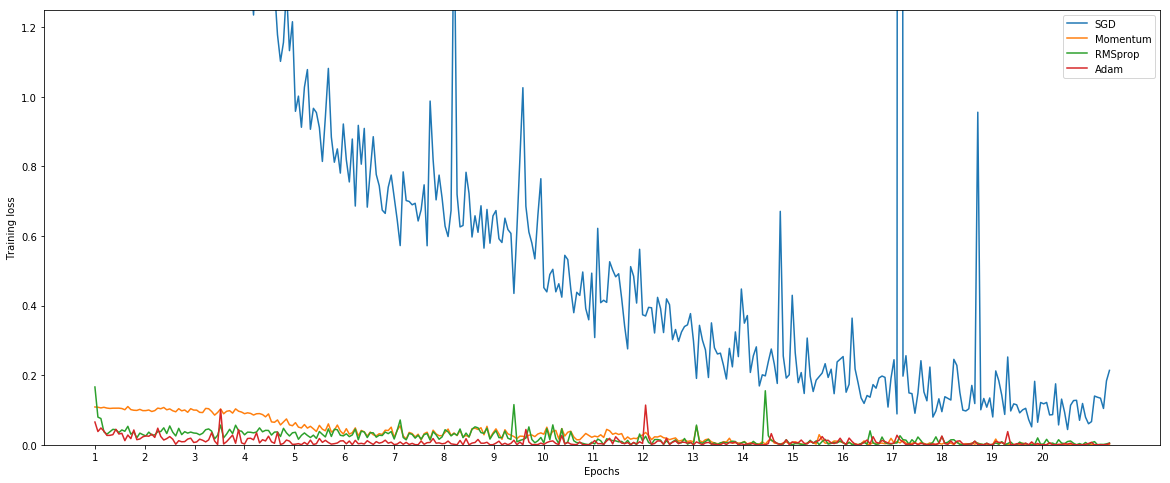

In [117]:
lo = [SGDl,Moml,RMSl,Adaml]

fig,ax = plt.subplots()
fig.set_size_inches(20,8)
for i, k in enumerate(lo):
    plt.plot(k,label = name[i])
    plt.ylim(0,1.25)
    plt.xticks([w*len(X_train)/340 for w in range(20)],['%i'%w for w in range(1,21)])
    plt.xlabel("Epochs")
    plt.ylabel("Training loss")
    plt.legend()

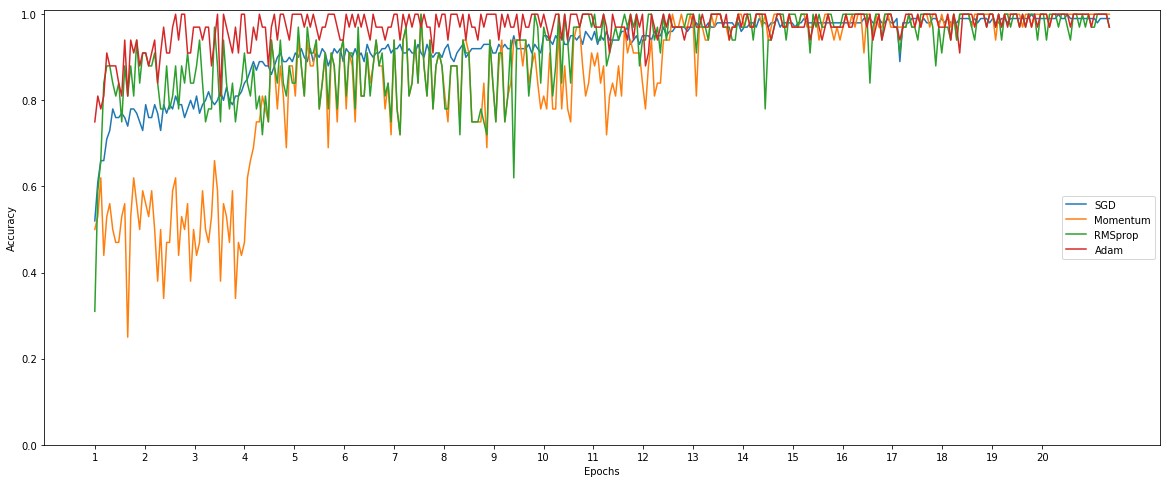

In [125]:
acc = [SGDa,Moma,RMSa,Adama]

fig,ax = plt.subplots()
fig.set_size_inches(20,8)
for i, k in enumerate(acc):
    plt.plot(k,label = name[i])
    plt.ylim(0,1.01)
    plt.xticks([w*len(X_train)/340 for w in range(20)],['%i'%w for w in range(1,21)])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc=7)

## Accuracy

In [126]:
correct = 0
total = 0
c0 = 0
c1 = 0
c2 = 0
y_hat = []
y_t = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data 
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net_Adam(images)
        _,predicted = torch.max(outputs.data,1)
        print(outputs.data)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        c0 += (predicted == 0).sum()
        c1 += (predicted == 1).sum()
        c2 += (predicted == 2).sum()
        for i in range(0,len(predicted)):
            y_hat.append(predicted[i])
            y_t.append(labels[i])

In [127]:
print("Accuracy of the network on the test images:", round((100 * float(correct) / total),2))

Accuracy of the network on the test images: 97.13


In [128]:
print("Correct Values", correct)
print("Total Values",total)

Correct Values tensor(2710, device='cuda:0')
Total Values 2790


Confusion matrix, without normalization
[[1496    8    1]
 [   5  860   27]
 [   1   38  354]]
Normalized confusion matrix
[[9.94e-01 5.32e-03 6.64e-04]
 [5.61e-03 9.64e-01 3.03e-02]
 [2.54e-03 9.67e-02 9.01e-01]]


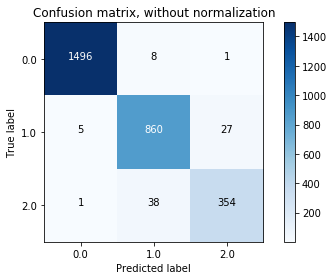

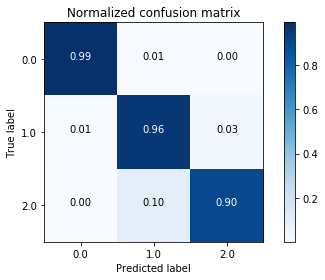

In [129]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t, np.asarray(y_hat))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=Y9_unique,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=Y9_unique, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Total class 0 predictions

In [130]:
print("Predicted 0's :",int(c0),"\nTrue 0's      :",sum(Y_test==0))

Predicted 0's : 1502 
True 0's      : 1505


### Total class 1 predictions

In [131]:
print("Predicted 1's :",int(c1),"\nTrue 1's      :",sum(Y_test==1))

Predicted 1's : 906 
True 1's      : 892


### Total class 2 predictions

In [132]:
print("Predicted 2's :",int(c2),"\nTrue 2's      :",sum(Y_test==2))

Predicted 2's : 382 
True 2's      : 393


In [133]:
correct = 0
total = 0
t0 = 0
t1 = 0
t2 = 0
y_hat = []
y_t = []
with torch.no_grad():
    for data in train_loader:
        images, labels = data 
        images = images.to(device)
        labels = labels.to(device)
               
        outputs = net_Adam(images)
        _,predicted = torch.max(outputs.data,1)
        print(outputs.data)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        t0 += (predicted == 0).sum()
        t1 += (predicted == 1).sum()
        t2 += (predicted == 2).sum()
        
        for i in range(0,32):
            y_hat.append(predicted[i])
            y_t.append(labels[i])

tensor([[  -20.6703,     8.9179,    -4.5426],
        [   90.0088,  -210.2861,  -371.8558],
        [  137.5187,  -322.7501,  -574.4214],
        [  -27.0238,    11.2485,    -7.3113],
        [  789.4854, -1869.2014, -3368.2400],
        [  -22.5859,     9.8166,    -4.7083],
        [  -14.9833,     6.5491,    -3.2461],
        [  -11.2981,     5.0754,    -1.9961],
        [  114.5596,  -269.1265,  -479.3185],
        [   23.8800,   -54.8644,   -94.2203],
        [   71.3020,  -165.7802,  -290.6365],
        [   -5.6545,     2.7876,    -0.0200],
        [  -13.0752,     5.8895,    -2.1550],
        [   78.3146,  -182.2399,  -319.8629],
        [  248.9556,  -586.1711, -1048.4386],
        [   -1.2872,     0.7509,     0.1889],
        [  245.6288,  -578.1700, -1033.5740],
        [  -69.7387,    26.6919,   -25.9214],
        [  -11.8521,     0.1814,     4.5353],
        [   90.1425,  -209.8991,  -368.6718],
        [   65.9780,  -153.7349,  -270.5484],
        [  -16.8118,     0.2014,  

tensor([[  -92.9292,    35.1807,   -35.4804],
        [   63.0009,  -146.6165,  -257.5012],
        [  -68.5958,    26.6157,   -24.5039],
        [  373.3260,  -882.8226, -1588.9076],
        [   70.7468,  -164.7249,  -289.4584],
        [   48.8891,  -113.2807,  -196.9708],
        [  189.4568,  -447.9121,  -805.6946],
        [  173.5468,  -409.7583,  -735.3786],
        [   74.3288,  -172.9201,  -303.3298],
        [  -40.4581,    16.0700,   -13.6621],
        [  -82.6928,    30.1132,   -35.0328],
        [  -74.8675,    27.5241,   -31.0449],
        [  -17.4563,     0.2130,     6.7991],
        [  -13.1343,     5.3370,    -4.4835],
        [  130.0553,  -306.4831,  -548.8863],
        [  -35.2046,    14.6473,    -9.4888],
        [  -79.9405,    30.4651,   -30.1263],
        [  -21.4170,     9.2452,    -4.8281],
        [  -11.3810,     0.3306,     4.4621],
        [  -31.1755,    12.5667,   -10.0049],
        [   -1.4965,     0.7998,    -0.0853],
        [   70.3807,  -164.2644,  

tensor([[   69.4605,  -161.9101,  -284.9791],
        [  -55.3013,    20.2075,   -23.5036],
        [    0.1188,    -0.2240,    -0.8118],
        [  170.2973,  -400.1470,  -713.5139],
        [  -10.9299,     5.1129,    -0.8735],
        [   -6.2160,     0.1722,     2.2694],
        [  304.5121,  -720.3617, -1296.5133],
        [   77.7990,  -181.7068,  -320.9534],
        [   10.5395,   -24.0698,   -41.4996],
        [   24.9723,   -57.5824,  -100.2100],
        [   87.3723,  -204.5162,  -362.7168],
        [  -26.6289,     0.3304,    10.5494],
        [  -39.7709,    15.9630,   -12.8615],
        [  -48.5074,    18.9405,   -17.2920],
        [  -77.4117,    28.3303,   -32.3688],
        [  -30.8085,    12.6602,    -9.0454],
        [   71.5073,  -166.7426,  -293.6367],
        [  253.2042,  -598.1921, -1075.0884],
        [  277.1541,  -655.1188, -1178.2211],
        [   85.4961,  -199.6330,  -352.1552],
        [   62.8364,  -146.4542,  -257.8253],
        [  -36.9514,     0.5476,  

tensor([[   82.2134,  -191.5498,  -336.8110],
        [   78.4981,  -182.8659,  -321.5030],
        [  -10.8482,     0.1780,     4.1164],
        [  -11.5428,     5.2788,    -1.6915],
        [  -25.1777,    10.5252,    -6.7706],
        [  -24.9765,     0.2730,     9.8437],
        [  -53.7329,    21.0186,   -18.9301],
        [  -62.7408,    24.0372,   -23.3730],
        [  -12.0260,     5.3960,    -2.1117],
        [  -58.8526,    22.3007,   -22.6345],
        [   -7.8196,     0.1885,     2.9097],
        [  -17.0332,     0.1980,     6.5996],
        [   70.2164,  -163.4435,  -287.0811],
        [   70.5683,  -164.3032,  -288.7051],
        [  -90.8661,    34.1978,   -35.1054],
        [  -43.4551,    16.3792,   -17.1693],
        [  -11.5153,     0.1830,     4.4051],
        [   73.0080,  -169.9674,  -298.5903],
        [   70.7102,  -164.5601,  -288.8730],
        [   70.8224,  -164.9634,  -290.0658],
        [   85.8660,  -200.1211,  -352.0380],
        [   15.9555,   -36.6948,  

tensor([[  -48.9562,    19.3089,   -16.8373],
        [  112.9120,  -264.7722,  -470.7029],
        [  105.4086,  -246.4674,  -436.1828],
        [  -15.6640,     0.1944,     6.0321],
        [  -29.9591,     0.4472,    11.9681],
        [   -5.7857,     2.9091,     0.9313],
        [  -36.5235,    15.0694,   -10.2911],
        [  297.8254,  -702.0771, -1257.1630],
        [  -18.3660,     8.1510,    -3.2887],
        [   64.4580,  -150.1481,  -264.0799],
        [  -34.1476,    14.1206,    -9.3832],
        [  462.7628, -1093.6537, -1966.6110],
        [  -37.9527,    15.5071,   -11.2477],
        [   -3.8670,     1.9977,     0.7725],
        [  157.7047,  -371.6097,  -665.8788],
        [   81.9493,  -191.0885,  -336.4167],
        [  -31.7259,    12.5387,   -11.0807],
        [  -63.3190,    24.5000,   -22.8329],
        [   85.2337,  -198.8107,  -350.1484],
        [   61.4336,  -143.0470,  -251.4609],
        [   70.8310,  -165.0021,  -290.1491],
        [   62.3767,  -145.2763,  

tensor([[  165.6119,  -388.5320,  -690.4664],
        [  -16.9949,     0.3665,     6.6989],
        [   77.2435,  -180.4990,  -318.8382],
        [  221.7559,  -524.2762,  -942.8889],
        [  -23.3436,     9.7307,    -6.3650],
        [   53.8985,  -125.7275,  -221.7170],
        [  352.9106,  -835.4186, -1505.1924],
        [  -22.9349,     9.2876,    -7.3951],
        [   75.7323,  -176.9176,  -312.3871],
        [  -10.3037,     0.2826,     4.0027],
        [   74.9876,  -175.1372,  -309.1059],
        [  -25.3632,    11.4217,    -3.6895],
        [   75.0442,  -175.1570,  -308.8130],
        [  -17.1492,     7.5159,    -3.4664],
        [  124.1809,  -292.8257,  -525.3252],
        [  -27.8991,    10.4988,   -11.5046],
        [  -15.0152,     0.2399,     5.8515],
        [   54.4432,  -126.9850,  -223.9131],
        [   56.3650,  -131.4494,  -231.6952],
        [ -145.3509,    53.2233,   -60.1898],
        [  -16.1894,     0.1995,     6.2660],
        [   55.3970,  -129.1451,  

tensor([[  -37.6116,    14.8312,   -13.0197],
        [   85.2687,  -198.6566,  -349.2379],
        [   84.5745,  -197.5478,  -348.9508],
        [   85.3828,  -198.9491,  -349.8602],
        [  -11.0983,     0.1796,     4.2273],
        [   -6.3164,     2.8899,    -1.3130],
        [  -38.9528,    15.8751,   -11.6076],
        [  -21.3549,     9.4322,    -3.9601],
        [  200.3077,  -472.1166,  -845.7234],
        [   71.8408,  -167.2427,  -293.7964],
        [  -11.3943,     0.1821,     4.3538],
        [  295.1007,  -697.5150, -1254.5983],
        [  -37.3598,    14.9013,   -12.5558],
        [   -3.0016,     0.2176,     1.0130],
        [  -35.8439,    14.4380,   -11.5193],
        [  -24.5666,     0.3118,     9.7144],
        [  116.8786,  -273.8983,  -486.6141],
        [   80.5272,  -187.6038,  -329.8672],
        [   80.5805,  -187.4353,  -328.6890],
        [  -14.1695,     0.1916,     5.4690],
        [  -15.2444,     0.1931,     5.8874],
        [   67.9692,  -158.1623,  

tensor([[  468.4544, -1109.4130, -1999.9893],
        [ -135.5398,    50.1343,   -54.8969],
        [   91.3491,  -214.4245,  -381.8276],
        [  -50.6544,    18.6004,   -21.3335],
        [  311.1014,  -736.0397, -1325.4373],
        [  544.6773, -1290.4255, -2327.3616],
        [  -57.7212,    21.7623,   -22.5989],
        [   69.0331,  -161.2258,  -284.5631],
        [  -45.3490,    17.9942,   -15.3991],
        [ -146.4791,    55.0070,   -56.7937],
        [  -63.2396,    24.2966,   -23.4631],
        [  -17.3171,     0.2027,     6.7190],
        [  241.0047,  -567.9188, -1017.2249],
        [  359.7646,  -851.7231, -1535.5280],
        [  249.6289,  -590.4443, -1063.1451],
        [   67.4226,  -157.5039,  -278.1091],
        [   66.1794,  -154.5654,  -272.8372],
        [  154.9388,  -365.4930,  -655.8173],
        [  -27.9429,    11.4376,    -8.3807],
        [  194.5616,  -459.6008,  -826.4264],
        [  135.5471,  -320.1683,  -575.1246],
        [   43.3063,  -100.9388,  

tensor([[  131.5443,  -308.1400,  -545.2694],
        [   66.3350,  -155.2219,  -274.8270],
        [  -44.4983,    17.0717,   -16.8383],
        [  -70.9964,    25.8434,   -30.2558],
        [   63.0909,  -147.8907,  -262.6068],
        [  -42.2942,    17.4546,   -11.8323],
        [  432.0113, -1022.8657, -1843.0450],
        [  -56.4969,    22.0623,   -19.9153],
        [   69.6091,  -162.8864,  -288.3584],
        [  -22.7040,     9.7129,    -5.4147],
        [  266.2647,  -626.2209, -1117.7767],
        [  122.9532,  -288.7886,  -514.6252],
        [   63.1896,  -148.0728,  -262.7991],
        [   67.7458,  -158.5757,  -280.8942],
        [   92.7899,  -217.7270,  -386.8013],
        [  223.9458,  -529.4037,  -952.7290],
        [   86.7274,  -204.1012,  -364.6476],
        [   46.5558,  -108.8601,  -192.7402],
        [  -77.0285,    29.5924,   -28.5227],
        [  238.5281,  -563.8114, -1014.3245],
        [  -14.6617,     0.2279,     5.7027],
        [  -77.1399,    28.8613,  

tensor([[  125.7338,  -297.1330,  -534.6486],
        [  399.0787,  -943.6600, -1698.1259],
        [ -137.4556,    50.3054,   -57.2394],
        [  -57.8011,    22.3924,   -21.0274],
        [  115.7860,  -271.2644,  -481.4242],
        [  319.4747,  -756.2820, -1362.8458],
        [   67.9878,  -158.5378,  -279.2094],
        [   -3.9558,     1.9924,     0.1759],
        [  256.1624,  -605.8391, -1090.6166],
        [  -13.2880,     0.1873,     5.1085],
        [   59.6854,  -139.1875,  -245.3031],
        [   58.6650,  -136.7337,  -240.7333],
        [   19.7653,   -45.2365,   -77.5746],
        [  -15.4771,     0.1939,     5.9883],
        [  -14.4665,     6.3625,    -3.0065],
        [  183.1796,  -430.9591,  -769.8733],
        [   58.4537,  -136.2137,  -239.7574],
        [  -58.1673,    22.4472,   -21.3340],
        [  366.4827,  -866.9966, -1560.6307],
        [   64.1744,  -149.5847,  -263.3113],
        [  -53.3281,    19.1328,   -23.5954],
        [   68.4999,  -159.8770,  

tensor([[  93.2814, -217.9723, -385.0985],
        [  82.5834, -193.0576, -341.6408],
        [ 103.5291, -242.9970, -433.1825],
        [ -21.2379,    9.3351,   -3.9586],
        [-105.8557,   37.3778,  -47.5955],
        [  -6.9089,    3.1478,   -1.3671],
        [ -10.9631,    0.1825,    4.1577],
        [ -46.0947,   17.9827,  -16.5395],
        [ -45.8359,   18.3300,  -14.8136],
        [  86.9722, -202.4926, -355.6295],
        [ -15.0023,    6.2600,   -4.2755],
        [  78.6998, -183.4818, -323.1431],
        [ -17.7043,    7.7463,   -3.6034],
        [ 186.6011, -440.7060, -791.5040],
        [  85.1457, -199.0022, -352.7506],
        [ -12.2091,    5.5756,   -1.7423],
        [ -14.8112,    6.2932,   -3.8183],
        [  -9.1638,    4.2405,   -1.2435],
        [  66.4734, -154.6180, -271.3046],
        [  87.9544, -204.8015, -359.7456],
        [  -8.6422,    0.1795,    3.2547],
        [  92.6327, -215.7769, -379.2089],
        [ -26.4108,   10.5305,   -9.0736],
        [ -

tensor([[  -62.1128,    24.4987,   -21.1123],
        [   69.1681,  -161.1823,  -283.6205],
        [  -16.5487,     0.5111,     6.6782],
        [   79.8086,  -186.1320,  -327.8023],
        [   61.2976,  -142.7759,  -251.1237],
        [  -12.6749,     0.1874,     4.8427],
        [  -50.2709,    19.7162,   -17.5726],
        [   67.8248,  -158.0072,  -277.8980],
        [   76.7639,  -179.0017,  -315.2028],
        [   76.8315,  -179.1539,  -315.4606],
        [   -9.4958,     0.1926,     3.6160],
        [  -20.3131,     8.6501,    -5.0151],
        [   83.3128,  -194.3769,  -342.4908],
        [   -2.5400,     1.3579,     0.5264],
        [  -27.0289,    11.1028,    -7.9906],
        [  652.5873, -1545.7916, -2786.8328],
        [  -33.4119,    13.8703,    -9.0359],
        [  -20.2258,     0.3792,     8.0409],
        [   -2.0892,     1.1338,     0.3587],
        [  329.1880,  -777.7371, -1397.6825],
        [  509.1155, -1205.3097, -2171.3792],
        [  -15.7042,     0.1971,  

tensor([[  -19.9458,     8.8076,    -3.6159],
        [   58.2152,  -135.8638,  -239.7304],
        [  209.1372,  -492.7726,  -882.4374],
        [  539.1931, -1276.1761, -2298.7258],
        [  -31.0443,    12.6348,    -9.5408],
        [  200.3029,  -471.0780,  -841.2040],
        [   60.4347,  -141.1866,  -249.4596],
        [   73.5933,  -171.9663,  -303.7865],
        [   59.1379,  -138.2229,  -244.4641],
        [  -17.0411,     0.1988,     6.6002],
        [   76.1681,  -177.9789,  -314.3707],
        [   84.0584,  -196.6405,  -347.8363],
        [  -16.9285,     7.5575,    -2.9308],
        [  223.5623,  -528.2529,  -950.1958],
        [  -24.6638,     0.2858,     9.7326],
        [  -28.3700,    11.7587,    -7.8612],
        [  -24.8424,     0.2305,     9.7376],
        [   61.4752,  -143.4909,  -253.1878],
        [  264.5312,  -625.4913, -1125.4382],
        [ -122.9635,    45.0562,   -50.9895],
        [  353.9129,  -835.7969, -1502.6021],
        [   79.1434,  -185.0180,  

tensor([[   72.6430,  -170.1361,  -301.5702],
        [   69.5089,  -162.9386,  -289.2453],
        [  454.8655, -1075.9393, -1937.4874],
        [  -66.8233,    25.5362,   -25.0584],
        [  -83.1739,    31.6377,   -31.6403],
        [  104.2756,  -244.8491,  -436.2464],
        [   58.7977,  -137.5752,  -243.6362],
        [   73.4610,  -172.3969,  -307.2342],
        [  -50.7936,    19.8323,   -17.8907],
        [    5.6646,   -12.8878,   -22.1334],
        [  -90.0282,    33.3651,   -36.5756],
        [  -24.7828,     0.2345,     9.7243],
        [   53.6666,  -125.6656,  -222.8597],
        [  -33.9567,    14.1213,    -9.2891],
        [   54.2715,  -127.1034,  -225.4619],
        [  100.0984,  -235.7191,  -421.4758],
        [  275.0312,  -650.7772, -1172.0334],
        [   55.7698,  -130.5471,  -231.3825],
        [   66.0598,  -154.8424,  -274.8620],
        [   60.9156,  -142.4459,  -251.9556],
        [   52.3145,  -122.2834,  -216.2836],
        [ -120.6680,    44.7780,  

tensor([[   57.3572,  -133.9400,  -236.5571],
        [  -24.1293,    10.1347,    -6.2481],
        [  -43.9939,    17.4404,   -14.9139],
        [   69.7384,  -163.0578,  -288.3675],
        [   57.4295,  -134.0717,  -236.6848],
        [   58.6831,  -137.1244,  -242.3815],
        [  106.1883,  -249.1990,  -443.4694],
        [  258.0257,  -607.4153, -1085.6605],
        [  -14.6801,     6.2662,    -3.6462],
        [  112.9947,  -266.1472,  -476.1513],
        [   71.1774,  -166.2167,  -293.3604],
        [  152.7289,  -359.6530,  -643.3967],
        [  167.9449,  -395.3305,  -707.1877],
        [  130.0686,  -304.8182,  -541.3336],
        [  -21.2902,     0.3410,     8.4312],
        [   60.2043,  -140.4969,  -247.8568],
        [   70.4721,  -164.8859,  -292.2330],
        [  122.2567,  -288.5303,  -517.8780],
        [   -8.9333,     3.8939,    -2.2239],
        [   -4.9643,     2.4806,     0.5107],
        [   55.7041,  -129.9863,  -229.3341],
        [  176.3739,  -416.3188,  

tensor([[  -34.3733,    13.0768,   -13.4362],
        [   60.5222,  -141.1104,  -248.5819],
        [  -63.4874,    24.3317,   -23.6340],
        [  109.7570,  -258.3603,  -462.6346],
        [   72.5818,  -169.4546,  -298.9855],
        [  402.7398,  -949.7586, -1702.1434],
        [  140.2703,  -329.6340,  -588.1071],
        [   60.8544,  -141.8777,  -249.9094],
        [   73.5144,  -171.7735,  -303.5525],
        [  388.5694,  -920.3658, -1659.5819],
        [   -5.0918,     0.1800,     1.8301],
        [  -18.2242,     8.0049,    -3.5656],
        [   57.0606,  -133.0007,  -234.2172],
        [  143.8890,  -338.5927,  -605.4262],
        [   -0.3820,     0.2314,    -0.0582],
        [   59.6867,  -139.2040,  -245.5304],
        [  171.5438,  -403.4977,  -721.0535],
        [   -4.2085,     1.9249,    -1.1011],
        [  -56.7120,    22.3328,   -19.6216],
        [   57.4174,  -133.8551,  -235.7770],
        [  -31.0608,     0.6135,    12.5313],
        [  -20.6759,     8.5700,  

tensor([[  -13.2887,     0.1921,     5.1200],
        [   84.9936,  -198.4137,  -350.4700],
        [  -19.8546,     8.2575,    -5.5868],
        [   83.8469,  -195.2745,  -343.1407],
        [  -11.6407,     5.2949,    -1.7354],
        [  -48.9486,    19.0825,   -17.5091],
        [  -34.2031,    13.6176,   -11.5540],
        [  187.4383,  -441.9211,  -792.2631],
        [  379.0551,  -897.0521, -1616.0216],
        [  -71.9786,    27.9278,   -25.7319],
        [  -27.3254,     0.3809,    10.8666],
        [  -14.1076,     6.1868,    -2.9657],
        [  255.8922,  -605.1607, -1089.1716],
        [   80.4952,  -187.4044,  -329.1499],
        [   69.6485,  -162.0509,  -284.4453],
        [  275.0617,  -650.6262, -1170.4677],
        [  -74.9834,    27.8318,   -30.3295],
        [   63.0322,  -146.6111,  -257.3141],
        [  324.0487,  -765.7030, -1376.4274],
        [  -18.5319,     8.1842,    -3.4105],
        [   80.0531,  -186.3721,  -327.3451],
        [  -51.0371,    20.1523,  

tensor([[  -20.5887,     0.2115,     8.0331],
        [  -11.2267,     0.1834,     4.2835],
        [   76.0149,  -176.9914,  -310.8728],
        [   62.5171,  -145.0895,  -253.4869],
        [  -40.6117,    16.5447,   -12.0970],
        [  338.9029,  -801.4629, -1442.1743],
        [   74.9368,  -175.1191,  -309.6803],
        [  -12.4513,     5.7126,    -1.7141],
        [  -10.2672,     4.5083,    -2.3444],
        [  -92.7171,    34.4635,   -37.2920],
        [  216.0621,  -510.5869,  -917.7341],
        [  -34.3132,    13.7324,   -11.4666],
        [   89.1079,  -207.7547,  -365.6430],
        [  -16.4886,     7.2400,    -3.3324],
        [  -69.8845,    26.9404,   -25.5633],
        [   61.9776,  -144.2013,  -253.1762],
        [ -113.9606,    40.8719,   -49.8183],
        [   73.1837,  -170.4058,  -299.4244],
        [  -30.6946,    12.7459,    -8.3401],
        [   67.5916,  -157.5006,  -277.2473],
        [   86.4792,  -201.5437,  -354.4906],
        [  -94.8871,    35.2594,  

tensor([[   56.1996,  -131.3225,  -232.1552],
        [  -23.4709,    10.2638,    -4.5658],
        [  -50.6038,    20.0502,   -16.9918],
        [  -82.4075,    31.9060,   -29.6294],
        [   72.0525,  -168.4818,  -297.9229],
        [   57.0262,  -133.2543,  -235.5701],
        [  -64.1392,    25.3115,   -21.8255],
        [ -100.6105,    36.2017,   -43.6274],
        [  372.0516,  -879.0549, -1580.3492],
        [  -12.8793,     0.1893,     4.9411],
        [  129.5480,  -305.0066,  -545.0814],
        [   51.1311,  -119.4982,  -211.3484],
        [   56.0596,  -130.9558,  -231.4069],
        [  -37.1503,    15.2329,   -10.7738],
        [   56.0350,  -131.0168,  -231.8263],
        [  -39.1969,    14.7552,   -15.7487],
        [   72.9621,  -170.7074,  -302.1156],
        [  -17.5509,     7.8261,    -2.9756],
        [  -18.9733,     0.2809,     7.4638],
        [   52.0095,  -121.5666,  -215.0388],
        [  417.2267,  -986.6990, -1775.9664],
        [  -15.7013,     6.7435,  

tensor([[  163.6317,  -384.8350,  -687.1016],
        [  -42.4750,    16.8559,   -14.4699],
        [  -10.4602,     0.2046,     4.0023],
        [   -1.9198,     1.0400,     0.2161],
        [  109.5358,  -257.1170,  -457.7301],
        [  -80.1286,    29.8955,   -31.8739],
        [   -4.8872,     2.4392,     0.2248],
        [  -15.4723,     6.3570,    -5.1449],
        [  -39.0915,    16.0386,   -11.2664],
        [   66.8398,  -155.6577,  -273.6212],
        [   -6.1928,     2.8843,    -1.0126],
        [   66.1918,  -154.1324,  -270.9003],
        [  -12.4646,     5.6679,    -1.9633],
        [   -5.2123,     2.5034,    -0.4339],
        [   -8.9221,     4.2013,    -0.7503],
        [  -39.5802,    15.6884,   -13.5585],
        [  190.9603,  -450.7948,  -810.2583],
        [   78.7810,  -183.5976,  -322.9502],
        [  -59.4719,    22.8152,   -22.4690],
        [  -15.6533,     0.3094,     6.1654],
        [  122.0142,  -287.7290,  -515.9447],
        [   -1.6313,     0.5474,  

tensor([[ -15.9345,    0.2017,    6.1824],
        [  -1.7861,    0.9973,    0.3387],
        [ -79.8506,   31.5115,  -26.9938],
        [  85.3838, -199.0739, -350.4133],
        [ -95.7777,   35.0693,  -40.0124],
        [  49.8022, -115.6842, -202.7454],
        [  86.6083, -201.9490, -355.5307],
        [ -12.3102,    5.7545,   -1.0739],
        [ -68.3603,   25.6920,  -26.8005],
        [  -4.9372,    2.4625,    0.0584],
        [  59.0652, -137.3523, -241.0840],
        [ 147.6824, -348.2855, -625.0447],
        [  68.5879, -159.7265, -280.7999],
        [ -10.3127,    0.1773,    3.9030],
        [ -14.7005,    0.2275,    5.7177],
        [  80.9394, -188.6136, -331.7607],
        [ -10.6389,    0.1950,    4.0305],
        [  64.8486, -150.9625, -265.2650],
        [  82.9238, -193.2870, -340.0984],
        [  72.7230, -170.1721, -301.8253],
        [ -40.6043,   15.8851,  -14.5638],
        [ -16.4261,    6.8209,   -4.7519],
        [ -11.3769,    0.1867,    4.3572],
        [  

tensor([[   79.9714,  -186.1121,  -326.6476],
        [   -7.7336,     0.1784,     2.8738],
        [  -12.3616,     0.1831,     4.7210],
        [  -12.5361,     0.2004,     4.8331],
        [  -16.7459,     0.2018,     6.4998],
        [  110.4627,  -259.0212,  -460.4156],
        [  -45.2520,    18.1034,   -14.7683],
        [   82.1489,  -191.2618,  -335.9232],
        [  -24.5612,     0.5235,     9.8736],
        [  -38.7875,    15.0367,   -14.2015],
        [  252.8508,  -597.8672, -1075.8967],
        [   -7.8009,     0.1848,     2.9009],
        [   -7.7936,     3.5299,    -1.5543],
        [   77.8147,  -181.3088,  -318.9572],
        [   78.1176,  -181.8405,  -319.2986],
        [  -21.8465,     0.2299,     8.5559],
        [  168.9380,  -397.9658,  -712.3157],
        [  -20.8101,     0.2210,     8.1359],
        [   76.9424,  -179.1197,  -314.5990],
        [  277.7741,  -656.3179, -1179.6173],
        [   -6.8169,     0.1860,     2.5109],
        [  -80.3305,    29.6247,  

tensor([[  -14.4275,     0.1903,     5.5503],
        [  -12.9590,     5.9379,    -1.6960],
        [  -17.0744,     0.2105,     6.6398],
        [  -32.1527,     0.5044,    12.8779],
        [   56.3329,  -131.2402,  -230.9230],
        [   78.7349,  -183.8437,  -324.7382],
        [ -168.7587,    61.1037,   -71.3309],
        [   -7.5283,     3.6309,    -0.1884],
        [   61.1411,  -142.5478,  -251.0716],
        [   53.3042,  -124.2044,  -218.6272],
        [   38.1154,   -88.4916,  -154.7536],
        [  -23.7268,     9.2907,    -8.8272],
        [  -14.4240,     6.5119,    -2.4090],
        [  -25.0903,    10.2737,    -7.5175],
        [  116.9013,  -274.7722,  -490.2240],
        [  140.8999,  -332.7073,  -597.3074],
        [  -26.9461,    11.1061,    -7.7893],
        [   33.9059,   -77.9748,  -134.2094],
        [   90.8371,  -212.0477,  -373.3093],
        [   39.7606,   -92.0838,  -160.2491],
        [  296.5181,  -701.3674, -1262.8713],
        [   54.0545,  -126.0084,  

tensor([[  -14.5985,     0.1912,     5.6226],
        [  358.2000,  -846.0555, -1519.9602],
        [  245.8623,  -580.7444, -1043.6063],
        [   86.7009,  -203.3211,  -361.4968],
        [  -22.8586,     9.6348,    -5.8270],
        [   83.5799,  -194.5359,  -341.0919],
        [   86.4056,  -201.3233,  -353.9804],
        [  -11.8876,     5.0906,    -3.1022],
        [  -25.5001,    10.5227,    -7.3847],
        [  -21.3998,     9.1494,    -5.0348],
        [   68.5556,  -159.5161,  -280.0144],
        [   -4.0159,     2.1878,     1.2978],
        [  389.3486,  -920.8297, -1657.1294],
        [  179.1080,  -420.8395,  -750.0700],
        [  -10.3561,     0.1924,     3.9149],
        [   -7.9072,     0.1684,     2.9535],
        [  -19.0069,     0.2088,     7.4069],
        [  -76.7991,    29.3766,   -28.4111],
        [  -64.9708,    25.1891,   -23.6460],
        [  212.5910,  -502.2781,  -903.1937],
        [  -31.2090,    12.5746,    -9.9509],
        [   -2.8515,     1.5811,  

tensor([[   57.4454,  -133.9204,  -235.9002],
        [  -98.9286,    35.7218,   -42.5316],
        [   -9.7858,     0.1762,     3.6932],
        [  -12.5952,     0.1915,     4.8481],
        [  -96.4209,    35.9030,   -38.3867],
        [  -12.4879,     5.7961,    -1.3886],
        [  301.0847,  -712.5039, -1283.0562],
        [   86.1022,  -201.6488,  -358.0037],
        [   54.0545,  -125.9444,  -221.7203],
        [   62.9276,  -145.6110,  -252.6776],
        [   57.5979,  -134.3009,  -236.6326],
        [   47.5474,  -110.3732,  -193.0234],
        [  100.9651,  -236.9927,  -421.7886],
        [   47.9385,  -111.6705,  -196.6697],
        [ -155.8077,    55.8123,   -67.5933],
        [  -21.7246,     0.2260,     8.5040],
        [   69.8339,  -162.8974,  -287.0143],
        [  -21.9529,     0.2286,     8.5951],
        [  -35.8962,    14.2387,   -12.1389],
        [   53.6562,  -124.9977,  -219.9919],
        [   67.9384,  -158.6310,  -280.2768],
        [  -17.6741,     7.1643,  

In [134]:
print('Accuracy of the network on the train images:', round((100 * float(correct) / total),2))

Accuracy of the network on the train images: 99.54


Confusion matrix, without normalization
[[1443    7    0]
 [   4  888   42]
 [   1   13  392]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.95 0.04]
 [0.   0.03 0.97]]


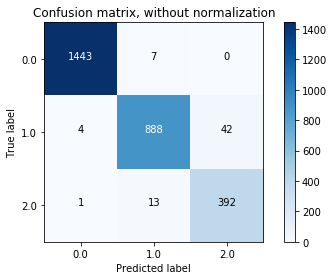

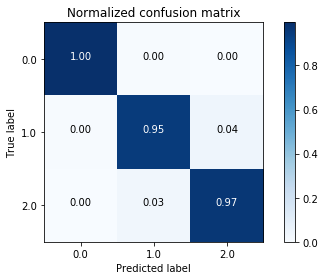

In [149]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, None]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t, np.asarray(y_hat))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=Y9_unique,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=Y9_unique, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Total class 0 predictions

In [120]:
print("Predicted 0's :",int(t0),"\nTrue 0's      :",sum(Y_train==0))

Predicted 0's : 2968 
True 0's      : 2963


### Total class 1 predictions

In [122]:
print("Predicted 1's :",int(t1),"\nTrue 1's      :",sum(Y_train==1))

Predicted 1's : 1910 
True 1's      : 1933


### Total class 2 predictions

In [123]:
print("Predicted 1's :",int(t2),"\nTrue 1's      :",sum(Y_train==2))

Predicted 1's : 786 
True 1's      : 768
